In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

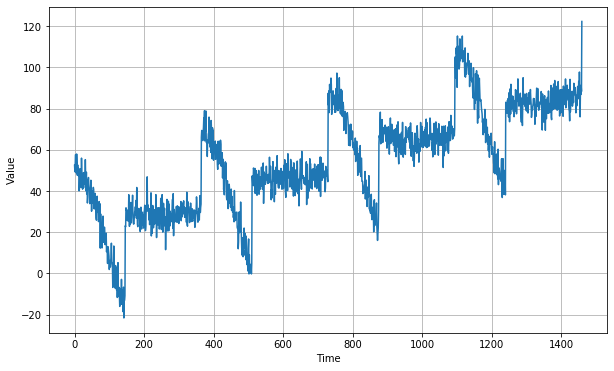

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Naive Forecast

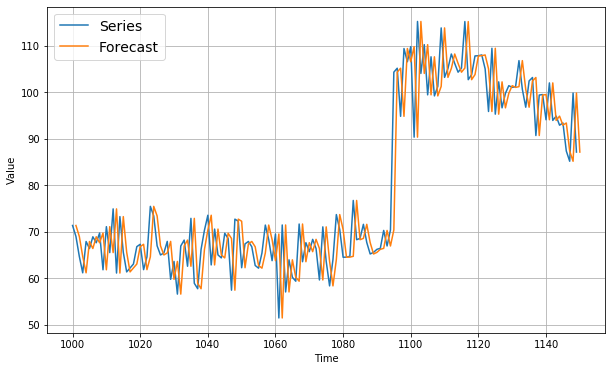

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

naive_forecast = series[split_time - 1:-1]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150, label="Series")
plot_series(time_valid, naive_forecast, start=1, end=151, label="Forecast")

In [6]:
keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()

5.9379085153216735

Moving Average

In [7]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

In [8]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast
     This implementation is *much* faster than the previous one"""
  mov = np.cumsum(series)
  mov[window_size:] = mov[window_size:] - mov[:-window_size]
  return mov[window_size - 1:-1] / window_size

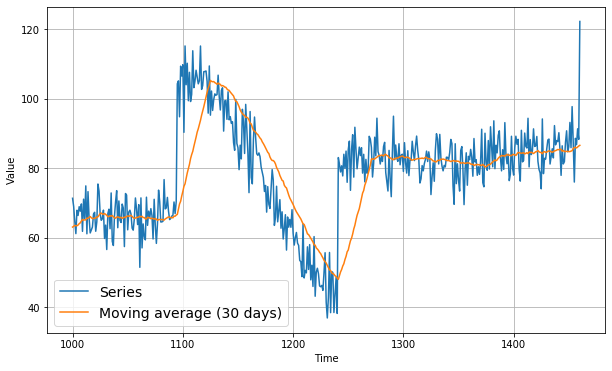

In [9]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, moving_avg, label="Moving average (30 days)")

In [10]:
keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()

7.1424185706207854

Removing seasonality

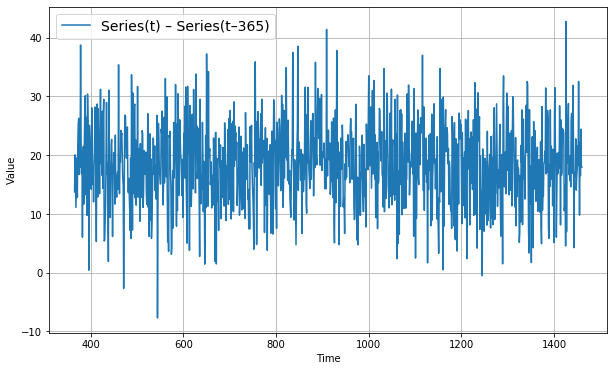

In [12]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series, label="Series(t) – Series(t–365)")
plt.show()

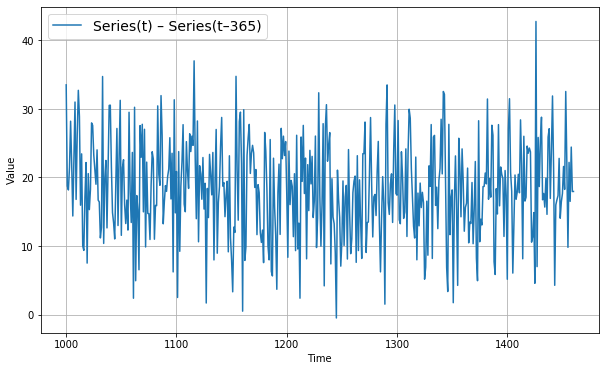

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:], label="Series(t) – Series(t–365)")
plt.show()

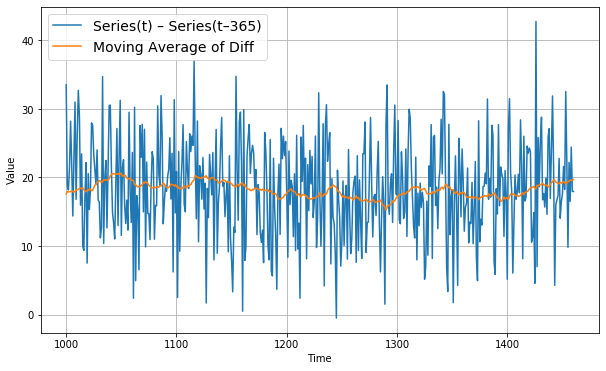

In [14]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:], label="Series(t) – Series(t–365)")
plot_series(time_valid, diff_moving_avg, label="Moving Average of Diff")
plt.show()

Now let's bring back the trend and seasonality by adding the past values from t – 365:

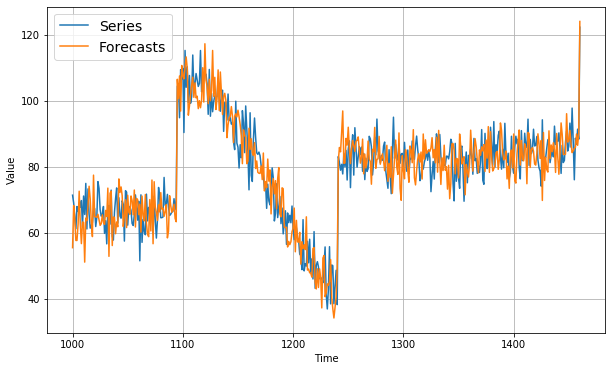

In [15]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_past, label="Forecasts")
plt.show()

In [16]:
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy()

5.8393105629958955

Better than naive forecast, good. However the forecasts look a bit too random, because we're just adding past values, which were noisy. Let's use a moving averaging on past values to remove some of the noise:

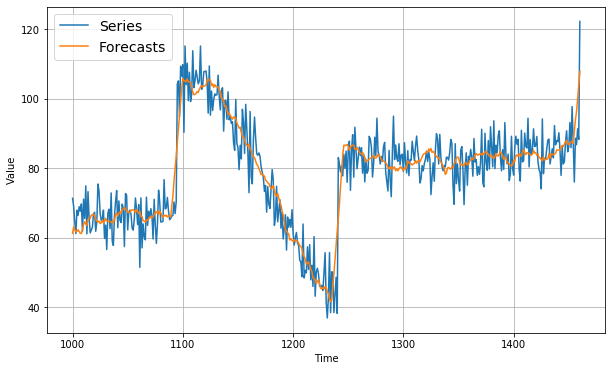

In [17]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-359], 11) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_smooth_past, label="Forecasts")
plt.show()

In [18]:
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy()

4.566859958970771

Forecasting with Machine Learning:
First, we will train a model to forecast the next step given the previous 30 steps, therefore, we need to create a dataset of 30-step windows for training.

In [20]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [21]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

Linear Model

In [23]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, validation_data=valid_set)

C:\Users\Aman Verma\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
31/31 [==============================] - 3s 40ms/step - loss: 46.6813 - mae: 47.1784 - val_loss: 23.1475 - val_mae: 23.6473
Epoch 2/100
31/31 [==============================] - 1s 24ms/step - loss: 11.9123 - mae: 12.4017 - val_loss: 10.6108 - val_mae: 11.0934
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 10.2063 - mae: 10.6947 - val_loss: 9.1115 - val_mae: 9.6013
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 9.8053 - mae: 10.2898 - val_loss: 9.0103 - val_mae: 9.4965
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 9.7068 - mae: 10.1940 - val_loss: 8.9696 - val_mae: 9.4569
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 9.5858 - mae: 10.0706 - val_loss: 9.2814 - val_mae: 9.7695
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 9.5716 - mae: 10.0561 - val_loss: 8.7506 - val_mae: 9.2409
Epoch 8/100
31/31 [==============================] - 0s 6ms/step - 

31/31 [==============================] - 0s 5ms/step - loss: 5.7668 - mae: 6.2473 - val_loss: 5.8891 - val_mae: 6.3675
Epoch 64/100
31/31 [==============================] - 0s 5ms/step - loss: 5.7735 - mae: 6.2540 - val_loss: 5.7918 - val_mae: 6.2716
Epoch 65/100
31/31 [==============================] - 0s 4ms/step - loss: 5.7196 - mae: 6.1992 - val_loss: 5.7822 - val_mae: 6.2677
Epoch 66/100
31/31 [==============================] - 0s 4ms/step - loss: 5.7195 - mae: 6.2001 - val_loss: 5.8370 - val_mae: 6.3169
Epoch 67/100
31/31 [==============================] - 0s 5ms/step - loss: 5.7116 - mae: 6.1953 - val_loss: 5.8026 - val_mae: 6.2866
Epoch 68/100
31/31 [==============================] - 0s 5ms/step - loss: 5.6455 - mae: 6.1273 - val_loss: 5.8970 - val_mae: 6.3825
Epoch 69/100
31/31 [==============================] - 0s 4ms/step - loss: 5.5995 - mae: 6.0752 - val_loss: 6.1008 - val_mae: 6.5871
Epoch 70/100
31/31 [==============================] - 0s 4ms/step - loss: 5.6110 - mae: 6

In [24]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 3ms/step - loss: 67.6867 - mae: 68.1863 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 52.3572 - mae: 52.8561 - lr: 1.0798e-06
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 34.6465 - mae: 35.1446 - lr: 1.1659e-06
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 17.6521 - mae: 18.1484 - lr: 1.2589e-06
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 8.4604 - mae: 8.9488 - lr: 1.3594e-06
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 7.9765 - mae: 8.4627 - lr: 1.4678e-06
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 7.9201 - mae: 8.4035 - lr: 1.5849e-06
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 7.8785 - mae: 8.3609 - lr: 1.7113e-06
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 7.8191 - mae: 8.3014 - lr: 1.84

31/31 [==============================] - 0s 2ms/step - loss: 5.1565 - mae: 5.6340 - lr: 2.7123e-04
Epoch 75/100
31/31 [==============================] - 0s 2ms/step - loss: 6.8743 - mae: 7.3584 - lr: 2.9286e-04
Epoch 76/100
31/31 [==============================] - 0s 2ms/step - loss: 7.7672 - mae: 8.2556 - lr: 3.1623e-04
Epoch 77/100
31/31 [==============================] - 0s 1ms/step - loss: 8.4800 - mae: 8.9657 - lr: 3.4145e-04
Epoch 78/100
31/31 [==============================] - 0s 2ms/step - loss: 6.5515 - mae: 7.0344 - lr: 3.6869e-04
Epoch 79/100
31/31 [==============================] - 0s 2ms/step - loss: 9.9568 - mae: 10.4424 - lr: 3.9811e-04
Epoch 80/100
31/31 [==============================] - 0s 3ms/step - loss: 8.6579 - mae: 9.1488 - lr: 4.2987e-04
Epoch 81/100
31/31 [==============================] - 0s 2ms/step - loss: 32.8849 - mae: 33.3816 - lr: 4.6416e-04
Epoch 82/100
31/31 [==============================] - 0s 2ms/step - loss: 23.0955 - mae: 23.5909 - lr: 5.0119e-04


[1e-06, 0.001, 0, 20]

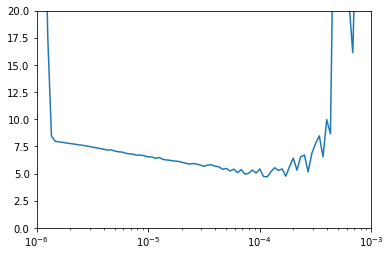

In [25]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [26]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500


C:\Users\Aman Verma\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


31/31 [==============================] - 1s 9ms/step - loss: 46.6813 - mae: 47.1784 - val_loss: 23.1475 - val_mae: 23.6473
Epoch 2/500
31/31 [==============================] - 0s 5ms/step - loss: 11.9123 - mae: 12.4017 - val_loss: 10.6108 - val_mae: 11.0934
Epoch 3/500
31/31 [==============================] - 0s 4ms/step - loss: 10.2063 - mae: 10.6947 - val_loss: 9.1115 - val_mae: 9.6013
Epoch 4/500
31/31 [==============================] - 0s 5ms/step - loss: 9.8053 - mae: 10.2898 - val_loss: 9.0103 - val_mae: 9.4965
Epoch 5/500
31/31 [==============================] - 0s 5ms/step - loss: 9.7068 - mae: 10.1940 - val_loss: 8.9696 - val_mae: 9.4569
Epoch 6/500
31/31 [==============================] - 0s 5ms/step - loss: 9.5858 - mae: 10.0706 - val_loss: 9.2814 - val_mae: 9.7695
Epoch 7/500
31/31 [==============================] - 0s 5ms/step - loss: 9.5716 - mae: 10.0561 - val_loss: 8.7506 - val_mae: 9.2409
Epoch 8/500
31/31 [==============================] - 0s 5ms/step - loss: 9.4335 -

31/31 [==============================] - 0s 5ms/step - loss: 5.7668 - mae: 6.2473 - val_loss: 5.8891 - val_mae: 6.3675
Epoch 64/500
31/31 [==============================] - 0s 4ms/step - loss: 5.7735 - mae: 6.2540 - val_loss: 5.7918 - val_mae: 6.2716
Epoch 65/500
31/31 [==============================] - 0s 6ms/step - loss: 5.7196 - mae: 6.1992 - val_loss: 5.7822 - val_mae: 6.2677
Epoch 66/500
31/31 [==============================] - 0s 5ms/step - loss: 5.7195 - mae: 6.2001 - val_loss: 5.8370 - val_mae: 6.3169
Epoch 67/500
31/31 [==============================] - 0s 4ms/step - loss: 5.7116 - mae: 6.1953 - val_loss: 5.8026 - val_mae: 6.2866
Epoch 68/500
31/31 [==============================] - 0s 4ms/step - loss: 5.6455 - mae: 6.1273 - val_loss: 5.8970 - val_mae: 6.3825
Epoch 69/500
31/31 [==============================] - 0s 4ms/step - loss: 5.5995 - mae: 6.0752 - val_loss: 6.1008 - val_mae: 6.5871
Epoch 70/500
31/31 [==============================] - 0s 4ms/step - loss: 5.6110 - mae: 6

Epoch 125/500
31/31 [==============================] - 0s 5ms/step - loss: 4.7014 - mae: 5.1780 - val_loss: 5.0025 - val_mae: 5.4797
Epoch 126/500
31/31 [==============================] - 0s 4ms/step - loss: 4.6727 - mae: 5.1444 - val_loss: 4.9720 - val_mae: 5.4553
Epoch 127/500
31/31 [==============================] - 0s 5ms/step - loss: 4.6785 - mae: 5.1538 - val_loss: 4.9888 - val_mae: 5.4690
Epoch 128/500
31/31 [==============================] - 0s 5ms/step - loss: 4.6817 - mae: 5.1575 - val_loss: 4.8904 - val_mae: 5.3673
Epoch 129/500
31/31 [==============================] - 0s 5ms/step - loss: 4.6582 - mae: 5.1312 - val_loss: 4.9069 - val_mae: 5.3925
Epoch 130/500
31/31 [==============================] - 0s 4ms/step - loss: 4.6306 - mae: 5.0997 - val_loss: 4.9076 - val_mae: 5.3829
Epoch 131/500
31/31 [==============================] - 0s 5ms/step - loss: 4.7226 - mae: 5.1940 - val_loss: 4.9074 - val_mae: 5.3918
Epoch 132/500
31/31 [==============================] - 0s 4ms/step - 

31/31 [==============================] - 0s 4ms/step - loss: 4.4405 - mae: 4.9176 - val_loss: 4.9912 - val_mae: 5.4687
Epoch 187/500
31/31 [==============================] - 0s 4ms/step - loss: 4.3811 - mae: 4.8573 - val_loss: 4.8905 - val_mae: 5.3692
Epoch 188/500
31/31 [==============================] - 0s 5ms/step - loss: 4.4497 - mae: 4.9265 - val_loss: 4.5827 - val_mae: 5.0545
Epoch 189/500
31/31 [==============================] - 0s 5ms/step - loss: 4.5007 - mae: 4.9756 - val_loss: 4.7732 - val_mae: 5.2578
Epoch 190/500
31/31 [==============================] - 0s 5ms/step - loss: 4.3986 - mae: 4.8711 - val_loss: 4.8453 - val_mae: 5.3263
Epoch 191/500
31/31 [==============================] - 0s 5ms/step - loss: 4.3835 - mae: 4.8578 - val_loss: 4.6002 - val_mae: 5.0768
Epoch 192/500
31/31 [==============================] - 0s 6ms/step - loss: 4.3800 - mae: 4.8554 - val_loss: 4.7555 - val_mae: 5.2396
Epoch 193/500
31/31 [==============================] - 0s 6ms/step - loss: 4.3818 -

In [27]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [28]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

15/15 [==============================] - 0s 7ms/step


In [29]:
lin_forecast.shape

(461,)

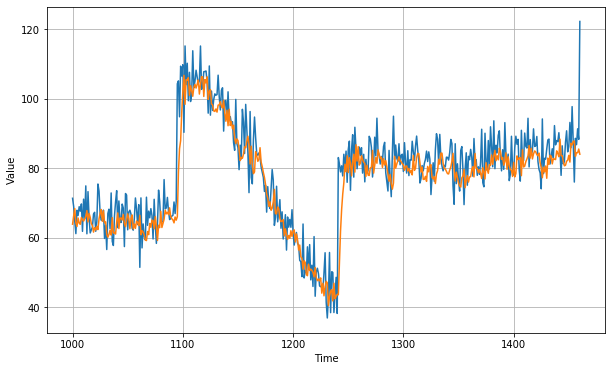

In [30]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [31]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

5.1662664

Dense Model Forecast

In [32]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


C:\Users\Aman Verma\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


31/31 [==============================] - 1s 3ms/step - loss: 43.8270 - mae: 44.3262 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 41.5210 - mae: 42.0202 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 38.6253 - mae: 39.1248 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 35.3203 - mae: 35.8201 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 31.5905 - mae: 32.0903 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 27.4033 - mae: 27.9022 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 22.7830 - mae: 23.2804 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 17.7632 - mae: 18.2594 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 12.6771 - mae: 13.1682 - lr: 2.5119

31/31 [==============================] - 0s 2ms/step - loss: 6.6666 - mae: 7.1523 - lr: 4.4668e-04
Epoch 75/100
31/31 [==============================] - 0s 2ms/step - loss: 5.1215 - mae: 5.6011 - lr: 5.0119e-04
Epoch 76/100
31/31 [==============================] - 0s 2ms/step - loss: 6.0278 - mae: 6.5107 - lr: 5.6234e-04
Epoch 77/100
31/31 [==============================] - 0s 1ms/step - loss: 5.1641 - mae: 5.6436 - lr: 6.3096e-04
Epoch 78/100
31/31 [==============================] - 0s 2ms/step - loss: 6.0188 - mae: 6.5025 - lr: 7.0795e-04
Epoch 79/100
31/31 [==============================] - 0s 1ms/step - loss: 7.7938 - mae: 8.2826 - lr: 7.9433e-04
Epoch 80/100
31/31 [==============================] - 0s 2ms/step - loss: 8.6213 - mae: 9.1077 - lr: 8.9125e-04
Epoch 81/100
31/31 [==============================] - 0s 2ms/step - loss: 6.2500 - mae: 6.7352 - lr: 0.0010
Epoch 82/100
31/31 [==============================] - 0s 2ms/step - loss: 7.2814 - mae: 7.7713 - lr: 0.0011
Epoch 83/100


[1e-07, 0.005, 0, 30]

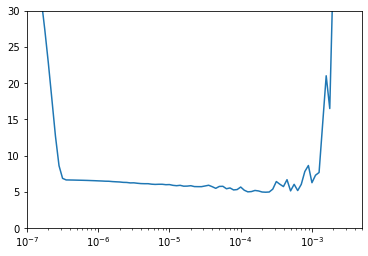

In [33]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

In [34]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500


C:\Users\Aman Verma\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


31/31 [==============================] - 1s 9ms/step - loss: 20.4049 - mae: 20.8986 - val_loss: 9.5125 - val_mae: 10.0037
Epoch 2/500
31/31 [==============================] - 0s 5ms/step - loss: 8.6179 - mae: 9.1027 - val_loss: 7.5804 - val_mae: 8.0585
Epoch 3/500
31/31 [==============================] - 0s 5ms/step - loss: 7.9849 - mae: 8.4702 - val_loss: 7.2411 - val_mae: 7.7189
Epoch 4/500
31/31 [==============================] - 0s 5ms/step - loss: 7.6780 - mae: 8.1603 - val_loss: 7.0971 - val_mae: 7.5798
Epoch 5/500
31/31 [==============================] - 0s 5ms/step - loss: 7.4285 - mae: 7.9136 - val_loss: 6.6877 - val_mae: 7.1663
Epoch 6/500
31/31 [==============================] - 0s 4ms/step - loss: 7.2165 - mae: 7.6989 - val_loss: 6.7449 - val_mae: 7.2319
Epoch 7/500
31/31 [==============================] - 0s 5ms/step - loss: 7.0491 - mae: 7.5318 - val_loss: 6.3436 - val_mae: 6.8156
Epoch 8/500
31/31 [==============================] - 0s 5ms/step - loss: 6.9028 - mae: 7.384

31/31 [==============================] - 0s 5ms/step - loss: 5.1874 - mae: 5.6697 - val_loss: 5.0692 - val_mae: 5.5508
Epoch 64/500
31/31 [==============================] - 0s 4ms/step - loss: 5.1751 - mae: 5.6555 - val_loss: 5.2834 - val_mae: 5.7662
Epoch 65/500
31/31 [==============================] - 0s 5ms/step - loss: 5.2088 - mae: 5.6886 - val_loss: 5.0484 - val_mae: 5.5301
Epoch 66/500
31/31 [==============================] - 0s 4ms/step - loss: 5.1744 - mae: 5.6535 - val_loss: 5.1831 - val_mae: 5.6589
Epoch 67/500
31/31 [==============================] - 0s 5ms/step - loss: 5.1534 - mae: 5.6338 - val_loss: 5.0369 - val_mae: 5.5184
Epoch 68/500
31/31 [==============================] - 0s 5ms/step - loss: 5.1575 - mae: 5.6382 - val_loss: 5.0227 - val_mae: 5.5027
Epoch 69/500
31/31 [==============================] - 0s 5ms/step - loss: 5.1541 - mae: 5.6362 - val_loss: 5.1051 - val_mae: 5.5804
Epoch 70/500
31/31 [==============================] - 0s 5ms/step - loss: 5.1305 - mae: 5

Epoch 125/500
31/31 [==============================] - 0s 4ms/step - loss: 4.7814 - mae: 5.2602 - val_loss: 4.7709 - val_mae: 5.2495
Epoch 126/500
31/31 [==============================] - 0s 4ms/step - loss: 4.7547 - mae: 5.2327 - val_loss: 4.7648 - val_mae: 5.2428
Epoch 127/500
31/31 [==============================] - 0s 4ms/step - loss: 4.7337 - mae: 5.2090 - val_loss: 4.8925 - val_mae: 5.3660
Epoch 128/500
31/31 [==============================] - 0s 5ms/step - loss: 4.7231 - mae: 5.2004 - val_loss: 4.7861 - val_mae: 5.2643
Epoch 129/500
31/31 [==============================] - 0s 4ms/step - loss: 4.7312 - mae: 5.2095 - val_loss: 4.7655 - val_mae: 5.2437
Epoch 130/500
31/31 [==============================] - 0s 5ms/step - loss: 4.7267 - mae: 5.2040 - val_loss: 4.7819 - val_mae: 5.2601
Epoch 131/500
31/31 [==============================] - 0s 5ms/step - loss: 4.8444 - mae: 5.3232 - val_loss: 4.9965 - val_mae: 5.4721
Epoch 132/500
31/31 [==============================] - 0s 4ms/step - 

In [35]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 [==============================] - 0s 6ms/step


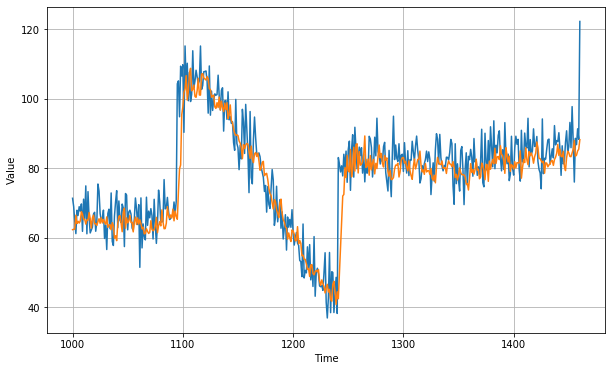

In [36]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [37]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

5.202555

Simple RNN Forecasting

In [38]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


C:\Users\Aman Verma\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


8/8 [==============================] - 2s 29ms/step - loss: 50.2169 - mae: 50.7167 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 25ms/step - loss: 23.0009 - mae: 23.4932 - lr: 1.1220e-07
Epoch 3/100
8/8 [==============================] - 0s 27ms/step - loss: 19.2073 - mae: 19.7003 - lr: 1.2589e-07
Epoch 4/100
8/8 [==============================] - 0s 28ms/step - loss: 16.9702 - mae: 17.4605 - lr: 1.4125e-07
Epoch 5/100
8/8 [==============================] - 0s 28ms/step - loss: 15.4093 - mae: 15.8988 - lr: 1.5849e-07
Epoch 6/100
8/8 [==============================] - 0s 29ms/step - loss: 14.7507 - mae: 15.2367 - lr: 1.7783e-07
Epoch 7/100
8/8 [==============================] - 0s 27ms/step - loss: 14.3058 - mae: 14.7931 - lr: 1.9953e-07
Epoch 8/100
8/8 [==============================] - 0s 25ms/step - loss: 14.0615 - mae: 14.5512 - lr: 2.2387e-07
Epoch 9/100
8/8 [==============================] - 0s 27ms/step - loss: 13.7812 - mae: 14.2687 - lr: 2.5119e-07
Epoc

8/8 [==============================] - 0s 26ms/step - loss: 751.4580 - mae: 751.9580 - lr: 3.9811e-04
Epoch 74/100
8/8 [==============================] - 0s 24ms/step - loss: 881.9222 - mae: 882.4222 - lr: 4.4668e-04
Epoch 75/100
8/8 [==============================] - 0s 26ms/step - loss: 940.5510 - mae: 941.0510 - lr: 5.0119e-04
Epoch 76/100
8/8 [==============================] - 0s 24ms/step - loss: 1061.6411 - mae: 1062.1411 - lr: 5.6234e-04
Epoch 77/100
8/8 [==============================] - 0s 24ms/step - loss: 1680.7195 - mae: 1681.2195 - lr: 6.3096e-04
Epoch 78/100
8/8 [==============================] - 0s 26ms/step - loss: 2879.8149 - mae: 2880.3149 - lr: 7.0795e-04
Epoch 79/100
8/8 [==============================] - 0s 28ms/step - loss: 2962.4133 - mae: 2962.9133 - lr: 7.9433e-04
Epoch 80/100
8/8 [==============================] - 0s 27ms/step - loss: 3075.9038 - mae: 3076.4036 - lr: 8.9125e-04
Epoch 81/100
8/8 [==============================] - 0s 27ms/step - loss: 3197.9602 

[1e-07, 0.0001, 0, 30]

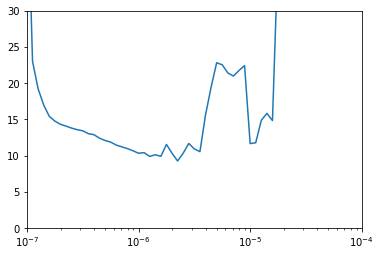

In [39]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [40]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500


C:\Users\Aman Verma\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


      8/Unknown - 2s 25ms/step - loss: 54.8857 - mae: 55.3843INFO:tensorflow:Assets written to: my_checkpoint\assets
8/8 [==============================] - 5s 558ms/step - loss: 54.8857 - mae: 55.3843 - val_loss: 53.7731 - val_mae: 54.2731
Epoch 2/500
8/8 [==============================] - 3s 472ms/step - loss: 35.4596 - mae: 35.9565 - val_loss: 17.5199 - val_mae: 18.0161
Epoch 3/500
8/8 [==============================] - 0s 46ms/step - loss: 22.5446 - mae: 23.0386 - val_loss: 18.8167 - val_mae: 19.3136
Epoch 4/500
8/8 [==============================] - 1s 47ms/step - loss: 16.2156 - mae: 16.7054 - val_loss: 20.0785 - val_mae: 20.5772
Epoch 5/500
8/8 [==============================] - 3s 386ms/step - loss: 13.7456 - mae: 14.2346 - val_loss: 6.8457 - val_mae: 7.3288
Epoch 6/500
8/8 [==============================] - 0s 46ms/step - loss: 11.3547 - mae: 11.8350 - val_loss: 7.2706 - val_mae: 7.7554
Epoch 7/500
8/8 [==============================] - 0s 45ms/step - loss: 10.7631 - mae: 11.24

8/8 [==============================] - 0s 45ms/step - loss: 6.2475 - mae: 6.7316 - val_loss: 9.4454 - val_mae: 9.9414
Epoch 54/500
8/8 [==============================] - 0s 42ms/step - loss: 6.6254 - mae: 7.1118 - val_loss: 5.1424 - val_mae: 5.6192
Epoch 55/500
8/8 [==============================] - 0s 43ms/step - loss: 6.7725 - mae: 7.2525 - val_loss: 5.7713 - val_mae: 6.2562
Epoch 56/500
8/8 [==============================] - 0s 43ms/step - loss: 6.9321 - mae: 7.4200 - val_loss: 5.7383 - val_mae: 6.2183
Epoch 57/500
8/8 [==============================] - 0s 43ms/step - loss: 5.8178 - mae: 6.2985 - val_loss: 5.1172 - val_mae: 5.5917
Epoch 58/500
8/8 [==============================] - 0s 46ms/step - loss: 6.0433 - mae: 6.5190 - val_loss: 7.4305 - val_mae: 7.9155
Epoch 59/500
8/8 [==============================] - 0s 45ms/step - loss: 5.7946 - mae: 6.2724 - val_loss: 6.6448 - val_mae: 7.1291
Epoch 60/500
8/8 [==============================] - 1s 51ms/step - loss: 5.6307 - mae: 6.1074 - 

Epoch 111/500
8/8 [==============================] - 1s 50ms/step - loss: 4.9848 - mae: 5.4589 - val_loss: 5.3269 - val_mae: 5.8102
Epoch 112/500
8/8 [==============================] - 1s 48ms/step - loss: 5.0177 - mae: 5.4948 - val_loss: 5.1846 - val_mae: 5.6698
Epoch 113/500
8/8 [==============================] - 1s 49ms/step - loss: 4.7052 - mae: 5.1779 - val_loss: 5.0071 - val_mae: 5.4804
Epoch 114/500
8/8 [==============================] - 1s 51ms/step - loss: 4.9924 - mae: 5.4697 - val_loss: 5.4819 - val_mae: 5.9590
Epoch 115/500
8/8 [==============================] - 1s 49ms/step - loss: 5.2149 - mae: 5.6951 - val_loss: 8.4176 - val_mae: 8.9079
Epoch 116/500
8/8 [==============================] - 1s 51ms/step - loss: 5.5694 - mae: 6.0533 - val_loss: 4.9969 - val_mae: 5.4694
Epoch 117/500
8/8 [==============================] - 1s 49ms/step - loss: 5.2112 - mae: 5.6912 - val_loss: 5.8994 - val_mae: 6.3906
Epoch 118/500
8/8 [==============================] - 0s 46ms/step - loss: 5.

In [41]:
model = keras.models.load_model("my_checkpoint")

In [42]:
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 [==============================] - 0s 10ms/step


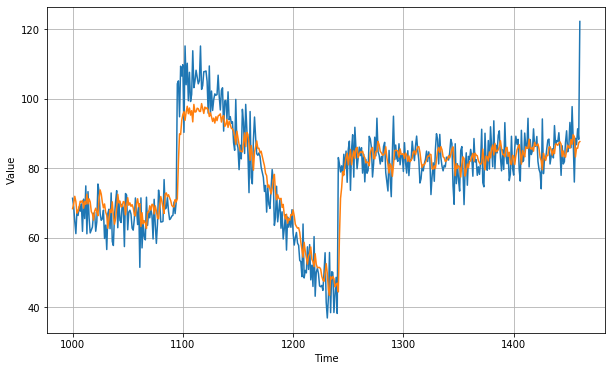

In [43]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [44]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.328211

Sequence to Sequence Forecasting

In [45]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [46]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]


In [47]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


C:\Users\Aman Verma\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


8/8 [==============================] - 2s 38ms/step - loss: 52.3615 - mae: 52.8611 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 34ms/step - loss: 25.4713 - mae: 25.9671 - lr: 1.0798e-07
Epoch 3/100
8/8 [==============================] - 0s 33ms/step - loss: 23.5029 - mae: 23.9971 - lr: 1.1659e-07
Epoch 4/100
8/8 [==============================] - 1s 57ms/step - loss: 21.1367 - mae: 21.6294 - lr: 1.2589e-07
Epoch 5/100
8/8 [==============================] - 0s 41ms/step - loss: 19.4762 - mae: 19.9674 - lr: 1.3594e-07
Epoch 6/100
8/8 [==============================] - 0s 38ms/step - loss: 18.6742 - mae: 19.1647 - lr: 1.4678e-07
Epoch 7/100
8/8 [==============================] - 0s 36ms/step - loss: 18.1698 - mae: 18.6587 - lr: 1.5849e-07
Epoch 8/100
8/8 [==============================] - 0s 36ms/step - loss: 17.7679 - mae: 18.2568 - lr: 1.7113e-07
Epoch 9/100
8/8 [==============================] - 1s 50ms/step - loss: 17.4389 - mae: 17.9280 - lr: 1.8478e-07
Epoc

Epoch 74/100
8/8 [==============================] - 0s 32ms/step - loss: 38.8881 - mae: 39.3876 - lr: 2.7123e-05
Epoch 75/100
8/8 [==============================] - 0s 34ms/step - loss: 41.3393 - mae: 41.8387 - lr: 2.9286e-05
Epoch 76/100
8/8 [==============================] - 0s 34ms/step - loss: 41.1273 - mae: 41.6265 - lr: 3.1623e-05
Epoch 77/100
8/8 [==============================] - 0s 33ms/step - loss: 43.1464 - mae: 43.6457 - lr: 3.4145e-05
Epoch 78/100
8/8 [==============================] - 0s 30ms/step - loss: 45.1440 - mae: 45.6438 - lr: 3.6869e-05
Epoch 79/100
8/8 [==============================] - 0s 33ms/step - loss: 46.3466 - mae: 46.8463 - lr: 3.9811e-05
Epoch 80/100
8/8 [==============================] - 0s 33ms/step - loss: 46.1646 - mae: 46.6643 - lr: 4.2987e-05
Epoch 81/100
8/8 [==============================] - 0s 32ms/step - loss: 47.6009 - mae: 48.1004 - lr: 4.6416e-05
Epoch 82/100
8/8 [==============================] - 0s 32ms/step - loss: 49.0305 - mae: 49.5302 

[1e-07, 0.0001, 0, 30]

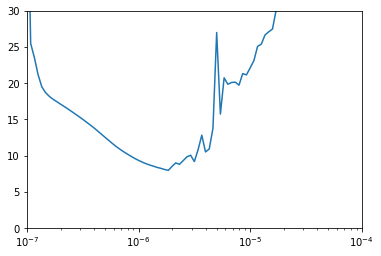

In [48]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [49]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500


C:\Users\Aman Verma\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


8/8 [==============================] - 2s 118ms/step - loss: 54.1427 - mae: 54.6412 - val_loss: 17.9209 - val_mae: 18.4158
Epoch 2/500
8/8 [==============================] - 1s 55ms/step - loss: 34.1721 - mae: 34.6694 - val_loss: 20.5481 - val_mae: 21.0440
Epoch 3/500
8/8 [==============================] - 1s 57ms/step - loss: 27.5074 - mae: 28.0027 - val_loss: 37.8711 - val_mae: 38.3706
Epoch 4/500
8/8 [==============================] - 1s 57ms/step - loss: 21.0646 - mae: 21.5578 - val_loss: 25.2685 - val_mae: 25.7674
Epoch 5/500
8/8 [==============================] - 1s 57ms/step - loss: 17.1768 - mae: 17.6667 - val_loss: 15.3555 - val_mae: 15.8505
Epoch 6/500
8/8 [==============================] - 1s 59ms/step - loss: 15.0382 - mae: 15.5247 - val_loss: 9.4217 - val_mae: 9.9070
Epoch 7/500
8/8 [==============================] - 1s 57ms/step - loss: 13.9508 - mae: 14.4372 - val_loss: 9.1618 - val_mae: 9.6475
Epoch 8/500
8/8 [==============================] - 1s 57ms/step - loss: 13.05

8/8 [==============================] - 1s 55ms/step - loss: 6.3027 - mae: 6.7813 - val_loss: 5.4634 - val_mae: 5.9396
Epoch 64/500
8/8 [==============================] - 1s 55ms/step - loss: 6.2800 - mae: 6.7595 - val_loss: 5.6596 - val_mae: 6.1384
Epoch 65/500
8/8 [==============================] - 1s 55ms/step - loss: 6.2597 - mae: 6.7382 - val_loss: 5.4920 - val_mae: 5.9685
Epoch 66/500
8/8 [==============================] - 1s 55ms/step - loss: 6.2370 - mae: 6.7161 - val_loss: 5.5227 - val_mae: 5.9986
Epoch 67/500
8/8 [==============================] - 1s 52ms/step - loss: 6.2181 - mae: 6.6968 - val_loss: 5.5079 - val_mae: 5.9838
Epoch 68/500
8/8 [==============================] - 1s 55ms/step - loss: 6.1976 - mae: 6.6767 - val_loss: 5.5154 - val_mae: 5.9910
Epoch 69/500
8/8 [==============================] - 1s 55ms/step - loss: 6.1796 - mae: 6.6588 - val_loss: 5.5413 - val_mae: 6.0176
Epoch 70/500
8/8 [==============================] - 1s 54ms/step - loss: 6.1641 - mae: 6.6427 - 

In [50]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 [==============================] - 1s 7ms/step


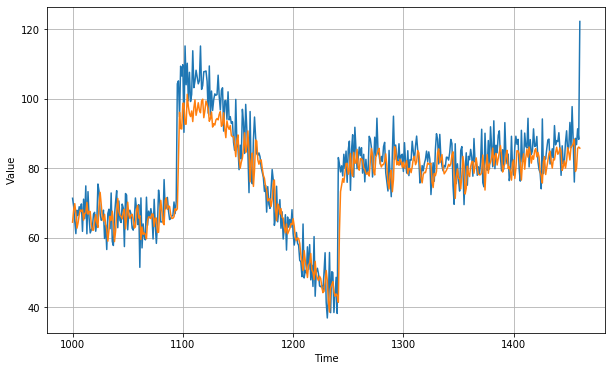

In [51]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [52]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.4588737

Forecasting with an LSTM

In [55]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [56]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100


C:\Users\Aman Verma\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


33/33 [==============================] - 4s 14ms/step - loss: 90.9191 - mae: 91.4191 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 0s 13ms/step - loss: 83.8978 - mae: 84.3978 - lr: 1.1220e-08
Epoch 3/100
33/33 [==============================] - 0s 13ms/step - loss: 75.4974 - mae: 75.9974 - lr: 1.2589e-08
Epoch 4/100
33/33 [==============================] - 0s 13ms/step - loss: 66.0676 - mae: 66.5676 - lr: 1.4125e-08
Epoch 5/100
33/33 [==============================] - 0s 13ms/step - loss: 55.5131 - mae: 56.0131 - lr: 1.5849e-08
Epoch 6/100
33/33 [==============================] - 0s 13ms/step - loss: 43.7599 - mae: 44.2597 - lr: 1.7783e-08
Epoch 7/100
33/33 [==============================] - 0s 13ms/step - loss: 30.7909 - mae: 31.2900 - lr: 1.9953e-08
Epoch 8/100
33/33 [==============================] - 0s 13ms/step - loss: 17.1478 - mae: 17.6436 - lr: 2.2387e-08
Epoch 9/100
33/33 [==============================] - 0s 13ms/step - loss: 10.0311 - mae: 10.5178 - l

33/33 [==============================] - 0s 13ms/step - loss: 11.1818 - mae: 11.6731 - lr: 3.9811e-05
Epoch 74/100
33/33 [==============================] - 0s 13ms/step - loss: 16.4653 - mae: 16.9577 - lr: 4.4668e-05
Epoch 75/100
33/33 [==============================] - 0s 14ms/step - loss: 13.4350 - mae: 13.9287 - lr: 5.0119e-05
Epoch 76/100
33/33 [==============================] - 0s 13ms/step - loss: 14.3078 - mae: 14.8034 - lr: 5.6234e-05
Epoch 77/100
33/33 [==============================] - 0s 13ms/step - loss: 16.3289 - mae: 16.8252 - lr: 6.3096e-05
Epoch 78/100
33/33 [==============================] - 0s 14ms/step - loss: 12.1998 - mae: 12.6912 - lr: 7.0795e-05
Epoch 79/100
33/33 [==============================] - 0s 14ms/step - loss: 9.4287 - mae: 9.9181 - lr: 7.9433e-05
Epoch 80/100
33/33 [==============================] - 0s 13ms/step - loss: 20.3495 - mae: 20.8463 - lr: 8.9125e-05
Epoch 81/100
33/33 [==============================] - 0s 13ms/step - loss: 14.8881 - mae: 15.38

[1e-08, 0.0001, 0, 30]

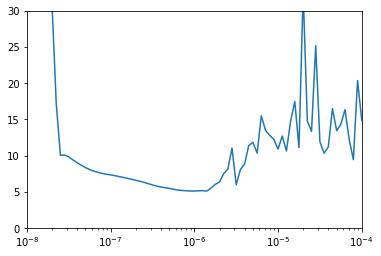

In [57]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [58]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=5e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500


C:\Users\Aman Verma\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


33/33 [==============================] - 4s 49ms/step - loss: 30.0122 - mae: 30.5050 - val_loss: 13.0810 - val_mae: 13.5746
Epoch 2/500
33/33 [==============================] - 1s 18ms/step - loss: 15.3618 - mae: 15.8570 - val_loss: 10.0991 - val_mae: 10.5941
Epoch 3/500
33/33 [==============================] - 1s 18ms/step - loss: 10.9284 - mae: 11.4173 - val_loss: 11.2192 - val_mae: 11.7083
Epoch 4/500
33/33 [==============================] - 1s 18ms/step - loss: 9.8165 - mae: 10.3052 - val_loss: 12.2806 - val_mae: 12.7757
Epoch 5/500
33/33 [==============================] - 1s 18ms/step - loss: 7.8424 - mae: 8.3317 - val_loss: 9.6437 - val_mae: 10.1336
Epoch 6/500
33/33 [==============================] - 1s 17ms/step - loss: 7.1708 - mae: 7.6561 - val_loss: 10.6124 - val_mae: 11.1036
Epoch 7/500
33/33 [==============================] - 1s 17ms/step - loss: 5.9200 - mae: 6.4041 - val_loss: 10.1595 - val_mae: 10.6522
Epoch 8/500
33/33 [==============================] - 1s 17ms/step - 

33/33 [==============================] - 1s 16ms/step - loss: 4.8800 - mae: 5.3581 - val_loss: 7.7570 - val_mae: 8.2442
Epoch 63/500
33/33 [==============================] - 1s 16ms/step - loss: 4.8741 - mae: 5.3520 - val_loss: 7.7333 - val_mae: 8.2205
Epoch 64/500
33/33 [==============================] - 1s 16ms/step - loss: 4.8722 - mae: 5.3498 - val_loss: 7.6966 - val_mae: 8.1836
Epoch 65/500
33/33 [==============================] - 1s 16ms/step - loss: 4.8715 - mae: 5.3490 - val_loss: 7.6494 - val_mae: 8.1360
Epoch 66/500
33/33 [==============================] - 1s 16ms/step - loss: 4.8703 - mae: 5.3477 - val_loss: 7.5974 - val_mae: 8.0836
Epoch 67/500
33/33 [==============================] - 1s 16ms/step - loss: 4.8670 - mae: 5.3447 - val_loss: 7.5479 - val_mae: 8.0336
Epoch 68/500
33/33 [==============================] - 1s 17ms/step - loss: 4.8605 - mae: 5.3386 - val_loss: 7.5021 - val_mae: 7.9872
Epoch 69/500
33/33 [==============================] - 1s 17ms/step - loss: 4.8501 

33/33 [==============================] - 1s 16ms/step - loss: 4.5731 - mae: 5.0498 - val_loss: 6.3979 - val_mae: 6.8793
Epoch 124/500
33/33 [==============================] - 1s 16ms/step - loss: 4.5806 - mae: 5.0581 - val_loss: 6.3476 - val_mae: 6.8284
Epoch 125/500
33/33 [==============================] - 1s 17ms/step - loss: 4.5904 - mae: 5.0685 - val_loss: 6.2877 - val_mae: 6.7682
Epoch 126/500
33/33 [==============================] - 1s 16ms/step - loss: 4.5976 - mae: 5.0764 - val_loss: 6.2279 - val_mae: 6.7074
Epoch 127/500
33/33 [==============================] - 1s 17ms/step - loss: 4.6012 - mae: 5.0806 - val_loss: 6.1625 - val_mae: 6.6409
Epoch 128/500
33/33 [==============================] - 1s 16ms/step - loss: 4.6009 - mae: 5.0804 - val_loss: 6.1093 - val_mae: 6.5874
Epoch 129/500
33/33 [==============================] - 1s 16ms/step - loss: 4.5965 - mae: 5.0762 - val_loss: 6.0682 - val_mae: 6.5464
Epoch 130/500
33/33 [==============================] - 1s 16ms/step - loss: 

33/33 [==============================] - 1s 16ms/step - loss: 4.4777 - mae: 4.9560 - val_loss: 5.8716 - val_mae: 6.3483
Epoch 185/500
33/33 [==============================] - 1s 16ms/step - loss: 4.4720 - mae: 4.9500 - val_loss: 5.8624 - val_mae: 6.3389
Epoch 186/500
33/33 [==============================] - 1s 16ms/step - loss: 4.4672 - mae: 4.9447 - val_loss: 5.8582 - val_mae: 6.3347
Epoch 187/500
33/33 [==============================] - 1s 16ms/step - loss: 4.4631 - mae: 4.9402 - val_loss: 5.8564 - val_mae: 6.3328
Epoch 188/500
33/33 [==============================] - 1s 17ms/step - loss: 4.4601 - mae: 4.9368 - val_loss: 5.8563 - val_mae: 6.3327
Epoch 189/500
33/33 [==============================] - 1s 16ms/step - loss: 4.4579 - mae: 4.9344 - val_loss: 5.8564 - val_mae: 6.3327
Epoch 190/500
33/33 [==============================] - 1s 16ms/step - loss: 4.4564 - mae: 4.9328 - val_loss: 5.8560 - val_mae: 6.3324
Epoch 191/500
33/33 [==============================] - 1s 16ms/step - loss: 

33/33 [==============================] - 1s 17ms/step - loss: 4.4047 - mae: 4.8817 - val_loss: 5.6029 - val_mae: 6.0811
Epoch 246/500
33/33 [==============================] - 1s 16ms/step - loss: 4.4197 - mae: 4.8962 - val_loss: 5.9536 - val_mae: 6.4329
Epoch 247/500
33/33 [==============================] - 1s 17ms/step - loss: 4.4003 - mae: 4.8781 - val_loss: 5.5586 - val_mae: 6.0373
Epoch 248/500
33/33 [==============================] - 1s 16ms/step - loss: 4.4205 - mae: 4.8971 - val_loss: 5.7749 - val_mae: 6.2515
Epoch 249/500
33/33 [==============================] - 1s 15ms/step - loss: 4.4011 - mae: 4.8782 - val_loss: 5.6106 - val_mae: 6.0893
Epoch 250/500
33/33 [==============================] - 1s 16ms/step - loss: 4.4031 - mae: 4.8793 - val_loss: 5.8892 - val_mae: 6.3674
Epoch 251/500
33/33 [==============================] - 1s 17ms/step - loss: 4.3910 - mae: 4.8678 - val_loss: 5.5497 - val_mae: 6.0284
Epoch 252/500
33/33 [==============================] - 1s 16ms/step - loss: 

33/33 [==============================] - 1s 16ms/step - loss: 4.3621 - mae: 4.8391 - val_loss: 5.4366 - val_mae: 5.9178
Epoch 307/500
33/33 [==============================] - 1s 16ms/step - loss: 4.3830 - mae: 4.8611 - val_loss: 5.6174 - val_mae: 6.0961
Epoch 308/500
33/33 [==============================] - 1s 16ms/step - loss: 4.3701 - mae: 4.8461 - val_loss: 5.8256 - val_mae: 6.3048
Epoch 309/500
33/33 [==============================] - 1s 15ms/step - loss: 4.3610 - mae: 4.8381 - val_loss: 5.4410 - val_mae: 5.9222
Epoch 310/500
33/33 [==============================] - 1s 16ms/step - loss: 4.3798 - mae: 4.8578 - val_loss: 5.6602 - val_mae: 6.1393
Epoch 311/500
33/33 [==============================] - 1s 16ms/step - loss: 4.3634 - mae: 4.8393 - val_loss: 5.8711 - val_mae: 6.3508
Epoch 312/500
33/33 [==============================] - 1s 16ms/step - loss: 4.3567 - mae: 4.8333 - val_loss: 5.4707 - val_mae: 5.9517
Epoch 313/500
33/33 [==============================] - 1s 16ms/step - loss: 

33/33 [==============================] - 1s 16ms/step - loss: 4.3421 - mae: 4.8184 - val_loss: 5.5137 - val_mae: 5.9941
Epoch 368/500
33/33 [==============================] - 1s 16ms/step - loss: 4.3641 - mae: 4.8403 - val_loss: 5.9784 - val_mae: 6.4592
Epoch 369/500
33/33 [==============================] - 1s 16ms/step - loss: 4.3465 - mae: 4.8235 - val_loss: 5.4154 - val_mae: 5.8969
Epoch 370/500
33/33 [==============================] - 1s 16ms/step - loss: 4.3695 - mae: 4.8474 - val_loss: 5.6038 - val_mae: 6.0834
Epoch 371/500
33/33 [==============================] - 1s 15ms/step - loss: 4.3589 - mae: 4.8348 - val_loss: 6.0443 - val_mae: 6.5263
Epoch 372/500
33/33 [==============================] - 1s 16ms/step - loss: 4.3455 - mae: 4.8224 - val_loss: 5.4417 - val_mae: 5.9230
Epoch 373/500
33/33 [==============================] - 1s 16ms/step - loss: 4.3623 - mae: 4.8398 - val_loss: 5.6857 - val_mae: 6.1660
Epoch 374/500
33/33 [==============================] - 1s 16ms/step - loss: 

33/33 [==============================] - 1s 17ms/step - loss: 4.3502 - mae: 4.8254 - val_loss: 6.1234 - val_mae: 6.6067
Epoch 429/500
33/33 [==============================] - 1s 16ms/step - loss: 4.3330 - mae: 4.8095 - val_loss: 5.4764 - val_mae: 5.9574
Epoch 430/500
33/33 [==============================] - 1s 16ms/step - loss: 4.3518 - mae: 4.8281 - val_loss: 5.7821 - val_mae: 6.2621
Epoch 431/500
33/33 [==============================] - 1s 16ms/step - loss: 4.3372 - mae: 4.8131 - val_loss: 5.9082 - val_mae: 6.3896
Epoch 432/500
33/33 [==============================] - 1s 17ms/step - loss: 4.3299 - mae: 4.8057 - val_loss: 5.7058 - val_mae: 6.1870
Epoch 433/500
33/33 [==============================] - 1s 16ms/step - loss: 4.3283 - mae: 4.8036 - val_loss: 5.9572 - val_mae: 6.4393
Epoch 434/500
33/33 [==============================] - 1s 17ms/step - loss: 4.3238 - mae: 4.7995 - val_loss: 5.4544 - val_mae: 5.9355
Epoch 435/500
33/33 [==============================] - 1s 20ms/step - loss: 

In [59]:
model = keras.models.load_model("my_checkpoint.h5")

In [60]:
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

1/1 [==============================] - 1s 869ms/step


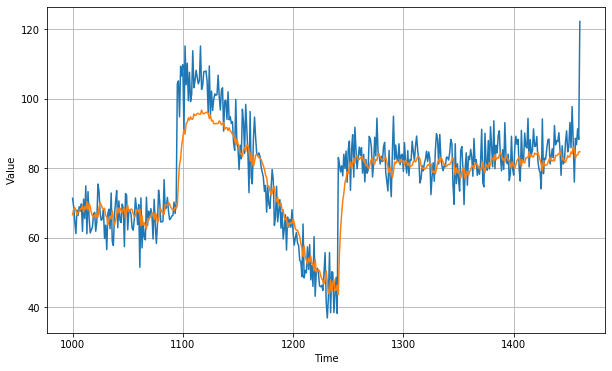

In [61]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [62]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.403204

Preprocessing with 1D-Convolutional Layers

In [63]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


C:\Users\Aman Verma\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


8/8 [==============================] - 5s 60ms/step - loss: 87.8346 - mae: 88.3341 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 37ms/step - loss: 87.1197 - mae: 87.6191 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 36ms/step - loss: 85.9241 - mae: 86.4234 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 39ms/step - loss: 84.3720 - mae: 84.8713 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 37ms/step - loss: 82.4703 - mae: 82.9696 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 37ms/step - loss: 80.2434 - mae: 80.7428 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 37ms/step - loss: 77.7459 - mae: 78.2453 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 37ms/step - loss: 75.0957 - mae: 75.5952 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 37ms/step - loss: 72.4508 - mae: 72.9503 - lr: 2.5119e-08
Epoc

8/8 [==============================] - 0s 33ms/step - loss: 7.0747 - mae: 7.5606 - lr: 4.4668e-05
Epoch 75/100
8/8 [==============================] - 0s 34ms/step - loss: 7.6379 - mae: 8.1240 - lr: 5.0119e-05
Epoch 76/100
8/8 [==============================] - 0s 32ms/step - loss: 12.1561 - mae: 12.6491 - lr: 5.6234e-05
Epoch 77/100
8/8 [==============================] - 0s 34ms/step - loss: 12.9874 - mae: 13.4808 - lr: 6.3096e-05
Epoch 78/100
8/8 [==============================] - 0s 38ms/step - loss: 9.9490 - mae: 10.4400 - lr: 7.0795e-05
Epoch 79/100
8/8 [==============================] - 0s 40ms/step - loss: 14.9050 - mae: 15.3982 - lr: 7.9433e-05
Epoch 80/100
8/8 [==============================] - 0s 37ms/step - loss: 12.8553 - mae: 13.3488 - lr: 8.9125e-05
Epoch 81/100
8/8 [==============================] - 0s 44ms/step - loss: 11.8311 - mae: 12.3227 - lr: 1.0000e-04
Epoch 82/100
8/8 [==============================] - 0s 35ms/step - loss: 10.0416 - mae: 10.5318 - lr: 1.1220e-04
E

[1e-08, 0.0001, 0, 30]

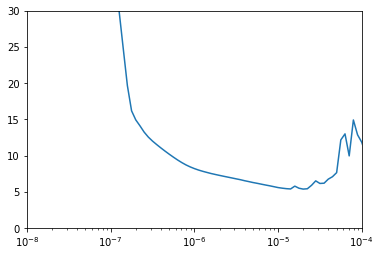

In [64]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [65]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500


C:\Users\Aman Verma\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


8/8 [==============================] - 5s 213ms/step - loss: 56.9010 - mae: 57.4001 - val_loss: 28.7748 - val_mae: 29.2719
Epoch 2/500
8/8 [==============================] - 1s 64ms/step - loss: 26.1449 - mae: 26.6407 - val_loss: 38.9231 - val_mae: 39.4212
Epoch 3/500
8/8 [==============================] - 1s 60ms/step - loss: 17.3629 - mae: 17.8585 - val_loss: 30.1023 - val_mae: 30.6011
Epoch 4/500
8/8 [==============================] - 1s 57ms/step - loss: 12.0091 - mae: 12.4990 - val_loss: 24.5628 - val_mae: 25.0602
Epoch 5/500
8/8 [==============================] - 1s 59ms/step - loss: 9.9288 - mae: 10.4167 - val_loss: 18.8857 - val_mae: 19.3824
Epoch 6/500
8/8 [==============================] - 1s 59ms/step - loss: 8.8391 - mae: 9.3253 - val_loss: 16.0113 - val_mae: 16.5062
Epoch 7/500
8/8 [==============================] - 1s 62ms/step - loss: 8.0840 - mae: 8.5699 - val_loss: 12.5161 - val_mae: 13.0055
Epoch 8/500
8/8 [==============================] - 1s 58ms/step - loss: 7.4687

8/8 [==============================] - 1s 54ms/step - loss: 4.5189 - mae: 4.9947 - val_loss: 6.3860 - val_mae: 6.8701
Epoch 64/500
8/8 [==============================] - 1s 52ms/step - loss: 4.5203 - mae: 4.9967 - val_loss: 6.6531 - val_mae: 7.1365
Epoch 65/500
8/8 [==============================] - 1s 55ms/step - loss: 4.5504 - mae: 5.0274 - val_loss: 5.9734 - val_mae: 6.4555
Epoch 66/500
8/8 [==============================] - 1s 59ms/step - loss: 4.5614 - mae: 5.0384 - val_loss: 6.2281 - val_mae: 6.7109
Epoch 67/500
8/8 [==============================] - 1s 57ms/step - loss: 4.5188 - mae: 4.9957 - val_loss: 6.5304 - val_mae: 7.0145
Epoch 68/500
8/8 [==============================] - 1s 65ms/step - loss: 4.5129 - mae: 4.9895 - val_loss: 6.1018 - val_mae: 6.5841
Epoch 69/500
8/8 [==============================] - 1s 55ms/step - loss: 4.4907 - mae: 4.9673 - val_loss: 6.2080 - val_mae: 6.6916
Epoch 70/500
8/8 [==============================] - 1s 50ms/step - loss: 4.4814 - mae: 4.9571 - 

8/8 [==============================] - 1s 51ms/step - loss: 4.2980 - mae: 4.7725 - val_loss: 5.6941 - val_mae: 6.1763
Epoch 126/500
8/8 [==============================] - 1s 52ms/step - loss: 4.2996 - mae: 4.7740 - val_loss: 5.6642 - val_mae: 6.1458
Epoch 127/500
8/8 [==============================] - 1s 52ms/step - loss: 4.2928 - mae: 4.7677 - val_loss: 5.7804 - val_mae: 6.2630
Epoch 128/500
8/8 [==============================] - 1s 50ms/step - loss: 4.2913 - mae: 4.7661 - val_loss: 5.5420 - val_mae: 6.0214
Epoch 129/500
8/8 [==============================] - 1s 52ms/step - loss: 4.2917 - mae: 4.7659 - val_loss: 5.6051 - val_mae: 6.0866
Epoch 130/500
8/8 [==============================] - 1s 53ms/step - loss: 4.2933 - mae: 4.7673 - val_loss: 5.7363 - val_mae: 6.2187
Epoch 131/500
8/8 [==============================] - 1s 50ms/step - loss: 4.2942 - mae: 4.7688 - val_loss: 5.6333 - val_mae: 6.1153
Epoch 132/500
8/8 [==============================] - 1s 54ms/step - loss: 4.2888 - mae: 4.

8/8 [==============================] - 1s 57ms/step - loss: 4.1816 - mae: 4.6547 - val_loss: 5.5438 - val_mae: 6.0256
Epoch 188/500
8/8 [==============================] - 1s 55ms/step - loss: 4.1780 - mae: 4.6512 - val_loss: 5.3174 - val_mae: 5.7969
Epoch 189/500
8/8 [==============================] - 1s 53ms/step - loss: 4.1821 - mae: 4.6557 - val_loss: 5.4117 - val_mae: 5.8923
Epoch 190/500
8/8 [==============================] - 1s 52ms/step - loss: 4.1827 - mae: 4.6560 - val_loss: 5.3709 - val_mae: 5.8512
Epoch 191/500
8/8 [==============================] - 1s 53ms/step - loss: 4.1820 - mae: 4.6561 - val_loss: 5.6393 - val_mae: 6.1212
Epoch 192/500
8/8 [==============================] - 1s 54ms/step - loss: 4.1799 - mae: 4.6537 - val_loss: 5.5045 - val_mae: 5.9862
Epoch 193/500
8/8 [==============================] - 1s 57ms/step - loss: 4.1768 - mae: 4.6500 - val_loss: 5.6971 - val_mae: 6.1786
Epoch 194/500
8/8 [==============================] - 1s 52ms/step - loss: 4.1734 - mae: 4.

8/8 [==============================] - 1s 52ms/step - loss: 4.1207 - mae: 4.5923 - val_loss: 5.2879 - val_mae: 5.7685
Epoch 250/500
8/8 [==============================] - 1s 50ms/step - loss: 4.1206 - mae: 4.5930 - val_loss: 5.3461 - val_mae: 5.8268
Epoch 251/500
8/8 [==============================] - 1s 52ms/step - loss: 4.1197 - mae: 4.5919 - val_loss: 5.2540 - val_mae: 5.7335
Epoch 252/500
8/8 [==============================] - 1s 54ms/step - loss: 4.1179 - mae: 4.5903 - val_loss: 5.1688 - val_mae: 5.6479
Epoch 253/500
8/8 [==============================] - 1s 57ms/step - loss: 4.1136 - mae: 4.5853 - val_loss: 5.1595 - val_mae: 5.6380
Epoch 254/500
8/8 [==============================] - 1s 52ms/step - loss: 4.1226 - mae: 4.5953 - val_loss: 5.1759 - val_mae: 5.6543
Epoch 255/500
8/8 [==============================] - 1s 50ms/step - loss: 4.1132 - mae: 4.5852 - val_loss: 5.3378 - val_mae: 5.8189
Epoch 256/500
8/8 [==============================] - 1s 52ms/step - loss: 4.1097 - mae: 4.

8/8 [==============================] - 1s 52ms/step - loss: 4.0843 - mae: 4.5560 - val_loss: 5.3266 - val_mae: 5.8076
Epoch 312/500
8/8 [==============================] - 1s 54ms/step - loss: 4.0889 - mae: 4.5603 - val_loss: 5.0733 - val_mae: 5.5525
Epoch 313/500
8/8 [==============================] - 1s 52ms/step - loss: 4.1018 - mae: 4.5742 - val_loss: 5.0705 - val_mae: 5.5479
Epoch 314/500
8/8 [==============================] - 1s 53ms/step - loss: 4.0932 - mae: 4.5649 - val_loss: 5.1205 - val_mae: 5.5993
Epoch 315/500
8/8 [==============================] - 1s 52ms/step - loss: 4.0764 - mae: 4.5475 - val_loss: 5.3250 - val_mae: 5.8059
Epoch 316/500
8/8 [==============================] - 1s 50ms/step - loss: 4.0819 - mae: 4.5535 - val_loss: 5.3326 - val_mae: 5.8135
Epoch 317/500
8/8 [==============================] - 1s 50ms/step - loss: 4.0877 - mae: 4.5600 - val_loss: 5.2708 - val_mae: 5.7513
Epoch 318/500
8/8 [==============================] - 1s 50ms/step - loss: 4.0710 - mae: 4.

8/8 [==============================] - 1s 52ms/step - loss: 4.0490 - mae: 4.5200 - val_loss: 5.0127 - val_mae: 5.4916
Epoch 374/500
8/8 [==============================] - 1s 54ms/step - loss: 4.0529 - mae: 4.5234 - val_loss: 5.1370 - val_mae: 5.6168
Epoch 375/500
8/8 [==============================] - 1s 53ms/step - loss: 4.0750 - mae: 4.5465 - val_loss: 5.5698 - val_mae: 6.0496
Epoch 376/500
8/8 [==============================] - 1s 54ms/step - loss: 4.0958 - mae: 4.5683 - val_loss: 5.3618 - val_mae: 5.8427
Epoch 377/500
8/8 [==============================] - 1s 54ms/step - loss: 4.0637 - mae: 4.5350 - val_loss: 5.2850 - val_mae: 5.7652
Epoch 378/500
8/8 [==============================] - 1s 52ms/step - loss: 4.0520 - mae: 4.5229 - val_loss: 5.2588 - val_mae: 5.7394
Epoch 379/500
8/8 [==============================] - 1s 52ms/step - loss: 4.0672 - mae: 4.5388 - val_loss: 5.3646 - val_mae: 5.8458
Epoch 380/500
8/8 [==============================] - 1s 55ms/step - loss: 4.0654 - mae: 4.

In [66]:
model = keras.models.load_model("my_checkpoint.h5")

In [67]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 [==============================] - 1s 11ms/step


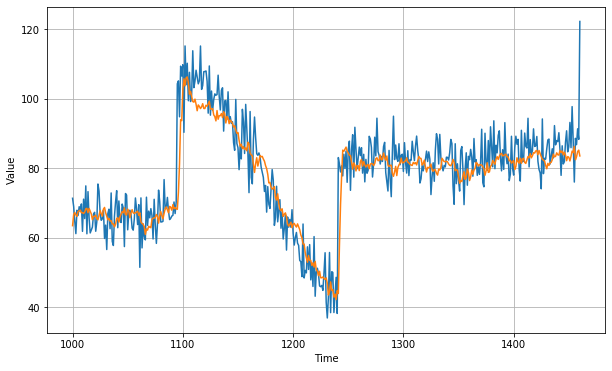

In [68]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)


In [69]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.112552

In [70]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


C:\Users\Aman Verma\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


8/8 [==============================] - 2s 87ms/step - loss: 42.2341 - mae: 42.7330 - lr: 1.0000e-04
Epoch 2/100
8/8 [==============================] - 1s 73ms/step - loss: 41.8293 - mae: 42.3284 - lr: 1.0798e-04
Epoch 3/100
8/8 [==============================] - 1s 60ms/step - loss: 41.4367 - mae: 41.9357 - lr: 1.1659e-04
Epoch 4/100
8/8 [==============================] - 1s 62ms/step - loss: 41.0108 - mae: 41.5098 - lr: 1.2589e-04
Epoch 5/100
8/8 [==============================] - 1s 72ms/step - loss: 40.4787 - mae: 40.9776 - lr: 1.3594e-04
Epoch 6/100
8/8 [==============================] - 1s 58ms/step - loss: 39.7341 - mae: 40.2328 - lr: 1.4678e-04
Epoch 7/100
8/8 [==============================] - 1s 57ms/step - loss: 38.5884 - mae: 39.0871 - lr: 1.5849e-04
Epoch 8/100
8/8 [==============================] - 1s 67ms/step - loss: 36.6836 - mae: 37.1823 - lr: 1.7113e-04
Epoch 9/100
8/8 [==============================] - 1s 58ms/step - loss: 33.3644 - mae: 33.8629 - lr: 1.8478e-04
Epoc

8/8 [==============================] - 1s 54ms/step - loss: 6.8334 - mae: 7.3173 - lr: 0.0316
Epoch 77/100
8/8 [==============================] - 1s 54ms/step - loss: 4.6392 - mae: 5.1156 - lr: 0.0341
Epoch 78/100
8/8 [==============================] - 1s 55ms/step - loss: 4.0362 - mae: 4.5088 - lr: 0.0369
Epoch 79/100
8/8 [==============================] - 1s 54ms/step - loss: 5.0414 - mae: 5.5174 - lr: 0.0398
Epoch 80/100
8/8 [==============================] - 1s 54ms/step - loss: 5.1927 - mae: 5.6704 - lr: 0.0430
Epoch 81/100
8/8 [==============================] - 1s 53ms/step - loss: 4.3486 - mae: 4.8224 - lr: 0.0464
Epoch 82/100
8/8 [==============================] - 1s 54ms/step - loss: 8.6859 - mae: 9.1704 - lr: 0.0501
Epoch 83/100
8/8 [==============================] - 1s 52ms/step - loss: 14.1759 - mae: 14.6650 - lr: 0.0541
Epoch 84/100
8/8 [==============================] - 1s 52ms/step - loss: 17.2455 - mae: 17.7349 - lr: 0.0584
Epoch 85/100
8/8 [============================

[0.0001, 0.1, 0, 30]

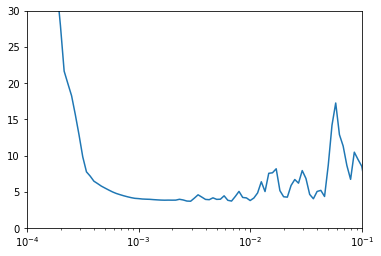

In [71]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [72]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=3e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500


C:\Users\Aman Verma\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


8/8 [==============================] - 2s 155ms/step - loss: 40.1883 - mae: 40.6871 - val_loss: 72.9189 - val_mae: 73.4189
Epoch 2/500
8/8 [==============================] - 1s 98ms/step - loss: 38.1153 - mae: 38.6140 - val_loss: 67.9778 - val_mae: 68.4778
Epoch 3/500
8/8 [==============================] - 1s 106ms/step - loss: 35.1358 - mae: 35.6344 - val_loss: 60.8665 - val_mae: 61.3665
Epoch 4/500
8/8 [==============================] - 1s 140ms/step - loss: 30.8281 - mae: 31.3263 - val_loss: 50.2195 - val_mae: 50.7191
Epoch 5/500
8/8 [==============================] - 1s 99ms/step - loss: 24.9596 - mae: 25.4564 - val_loss: 36.6520 - val_mae: 37.1480
Epoch 6/500
8/8 [==============================] - 1s 99ms/step - loss: 20.1383 - mae: 20.6330 - val_loss: 32.0186 - val_mae: 32.5158
Epoch 7/500
8/8 [==============================] - 1s 95ms/step - loss: 18.8909 - mae: 19.3859 - val_loss: 30.0781 - val_mae: 30.5755
Epoch 8/500
8/8 [==============================] - 1s 97ms/step - loss:

8/8 [==============================] - 1s 100ms/step - loss: 3.7912 - mae: 4.2611 - val_loss: 4.2371 - val_mae: 4.7115
Epoch 64/500
8/8 [==============================] - 1s 95ms/step - loss: 3.7850 - mae: 4.2550 - val_loss: 4.2404 - val_mae: 4.7151
Epoch 65/500
8/8 [==============================] - 1s 92ms/step - loss: 3.7799 - mae: 4.2500 - val_loss: 4.2562 - val_mae: 4.7312
Epoch 66/500
8/8 [==============================] - 1s 94ms/step - loss: 3.7745 - mae: 4.2443 - val_loss: 4.3037 - val_mae: 4.7808
Epoch 67/500
8/8 [==============================] - 1s 93ms/step - loss: 3.7748 - mae: 4.2445 - val_loss: 4.2583 - val_mae: 4.7334
Epoch 68/500
8/8 [==============================] - 1s 99ms/step - loss: 3.7632 - mae: 4.2329 - val_loss: 4.2116 - val_mae: 4.6857
Epoch 69/500
8/8 [==============================] - 1s 94ms/step - loss: 3.7551 - mae: 4.2242 - val_loss: 4.3058 - val_mae: 4.7831
Epoch 70/500
8/8 [==============================] - 1s 98ms/step - loss: 3.7535 - mae: 4.2230 -

8/8 [==============================] - 1s 100ms/step - loss: 3.4913 - mae: 3.9545 - val_loss: 4.1971 - val_mae: 4.6732
Epoch 126/500
8/8 [==============================] - 1s 94ms/step - loss: 3.4922 - mae: 3.9554 - val_loss: 4.2058 - val_mae: 4.6822
Epoch 127/500
8/8 [==============================] - 1s 93ms/step - loss: 3.4873 - mae: 3.9504 - val_loss: 4.2763 - val_mae: 4.7527
Epoch 128/500
8/8 [==============================] - 1s 93ms/step - loss: 3.4842 - mae: 3.9467 - val_loss: 4.2002 - val_mae: 4.6759
Epoch 129/500
8/8 [==============================] - 1s 89ms/step - loss: 3.4774 - mae: 3.9398 - val_loss: 4.1909 - val_mae: 4.6664
Epoch 130/500
8/8 [==============================] - 1s 93ms/step - loss: 3.4755 - mae: 3.9375 - val_loss: 4.2449 - val_mae: 4.7213
Epoch 131/500
8/8 [==============================] - 1s 95ms/step - loss: 3.4701 - mae: 3.9316 - val_loss: 4.2471 - val_mae: 4.7233
Epoch 132/500
8/8 [==============================] - 1s 94ms/step - loss: 3.4665 - mae: 3

In [73]:
model = keras.models.load_model("my_checkpoint.h5")

In [74]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

44/44 [==============================] - 1s 8ms/step


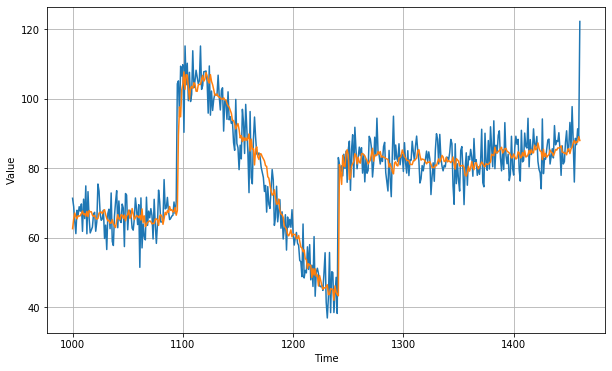

In [75]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [76]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

4.5255356